## Funciones e importaciones

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import pandas as pd
from scipy.integrate import simps
from scipy.integrate import odeint


'__Definición de funciones__'

def find_nearest(array, value):
    '''
    Recibe un array y un valor; devuelve el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def find_nearest_pos(array, value):
    '''
    Recibe un array y un valor; devuelve el índice del elemento con el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def eqX(y):
    '''
    Devuelve concentración de equilibrio en fase sólida a partir de una concentración en fase líquida
    '''
    KeqX = [15.80011045, 32.02907632, 5.735438305, 0.053726466, 1.972131456]
    eqX = KeqX[0]*KeqX[1]*y/(1+KeqX[1]*y)+KeqX[2] * KeqX[3]*(y-KeqX[4])/(1-KeqX[3]*(y-KeqX[4]))
    return eqX

def m(y):
    '''
    Devuelve el valor del coeficiente de distribución para una determinada concentración en fase líquida
    '''
    m = y/eqX(y)
    return m

def countercurrent(F, t):
    '''
    '''
    x = F[::2]
    y = F[1::2]

    x[0] = 0
    y[-1]= 0

    dFdt = np.empty_like(F)

    dxdt = dFdt[::2]
    dydt = dFdt[1::2]

    '____________________________________________________________________________________________'

    # En el punto de ingreso de sólidos (z = L) no hay variación en función del tiempo
    dxdt[0] = 0
    # A lo largo del extractor se considera la ecuación general
    conveccionS    = S/A * np.diff(x[:-1], 1)/dz
    transferenciaS = K * (x[1:-1] - eqX(y[1:-1]))
    dxdt[1:-1]     = (
        -conveccionS 
        #- transferenciaS
        )
    # 
    dxdt[-1]       = (-S/A*(x[-1]-x[-2])/dz - K*(x[-1] - eqX(y[-1])))

    '____________________________________________________________________________________________'

    dydt[0]        = (
        L/A*(y[1]-y[0])/dz 
        #+ (1-eps)*K*(x[-1] - eqX(y[0]))
        )/eps
        

    # A lo largo del extractor se considera la ecuación general
    difusionL      = Dax * np.diff(y[:], 2)/dz**2
    conveccionL    = L/A * np.diff(y[1:], 1)/dz
    transferenciaL = (1-eps)*K*(x[1:-1] - eqX(y[1:-1]))

    dydt[1:-1]     = (
        eps*difusionL 
        + conveccionL 
        #+ transferenciaL
        )/eps

    # En el punto de ingreso de solvente (z = 0) se considera que no hay acumulación

    dydt[-1]       = 0
    '____________________________________________________________________________________________'

    return dFdt

   
def error_porcentual(modelo):

    error_porcentual = 0

    for i, dato in enumerate(concentracion_experimental):

        tiempo = tiempo_experimental[i]
        posicion_t = find_nearest_pos(t/60,tiempo)
        
        error = abs((modelo[posicion_t, 1]-dato)/dato)
        error_porcentual += error

    return error_porcentual/(i+1)*100

## Parámetros

In [18]:



'__Fuente de gráficos__'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '9'


'__Datos Cinéticos Experimentales'
tiempo_experimental = [1,5,10,15,30,46,80,108,142,168,192,1263,1608]                             # min
concentracion_experimental = [0.11,0.21,0.3,0.46,0.72,0.93,1.3,1.37,1.59,1.62,1.58,1.64,1.76]    # g/L
datos_experimentales = [[tiempo_experimental],[concentracion_experimental]]


kb = 1.38*10**-23 # Constante de Boltzmann
e = math.e
pi = math.pi


# Temperatura de trabajo
T = 25 + 273


# Definición de propiedades
porcentajeAC = 0.06                                                 # Porcentaje de Ácido Carnósico
dens = 557.82                                                       # Densidad del sólido
densb = 130                                                         # Densidad del lecho
densL = 935.69                                                      # Densidad de fase líquida
Deff = (1.3*(10**-10))/60                                           # Difusividad efectiva en sólido
phi = 2.012453362                                                   # Factor de forma
a = 0.000706498099                                                  # Longitud característica
ap = 3362                                                           # Área equivalente
Deq = 6/ap                                                          # Diámetro equivalente a esfera
eps = 1.-densb/dens                                                 # Porosidad del lecho


# Propiedades estimadas
viscH2O = e**(
                - 52.843 + 3703.6/T
                + 5.866*math.log(T)
                - 5.98*10**(-29)*(T)**10
            )
viscEtOH = e**(
                7.875+781.98/T
                - 3.0418*math.log(T)
                ) 
visc = 0.01
rad = math.pow(326.5*(3/(4*pi)), 1/3)*10**(-10)                     # radio molecular de van der waals
Dab = kb*T/(6*pi*visc*rad)                                          # Ecuación de Einstein para difusividad


# Definición de parámetros de diseño
Lc = 10                                                             # Longitud del equipo
Dc = 0.35                                                           # Diámetro del equipo
A = math.pi*(Dc/2)**2                                               # Área del equipo


# Definición de parámetros de proceso
W = 1000/(3600*24*7*4)                                              # Materia prima a tratar, por hora (7 horas, 5 días, 4  semanas)
S = W/densb                                                         # Flujo volumétrico de sólidos (m³/s)
L = A*Lc*eps/(10*3600)                                              # Flujo volumétrico de solvente (m³/s)
tau = 24*3600                                                       # Tiempo máximo a calcular en la simulación


# Estimación de números adimensionales y coeficientes
Re = (L/A)*Deq*densL/(visc*(1-eps))                                 # Número de Reynolds
Pe = 0.2/eps + 0.011/eps + math.pow(eps*Re, 0.48)                   # Número de Peclet
Sc = visc/(densL*Dab)                                               # Numero de Schmidt   
ShL = (0.765/(Re**0.82) + 0.365/(Re**0.386))*Re*(Sc**(1/3))/eps     # Número de Sherwood
Dax = Deq*(L/A)/(eps*Pe)                                            # Dispersión axial
kL = ShL*Dab/a                                                      # Transferencia de masa en fase líquida


# Definición de la constante global de transferencia de masa
K = 8.07*10**-9
K = K*ap

K = 0.0003022438

# Cálculo de tiempos de residencia para el líquido y el sólido
resTimeL  = A*Lc*eps/L
resTimeS = A*Lc*(1-eps)/S



## Cálculos

In [19]:
'____Cálculos____'

# Número de puntos
nz = 100
nt = tau

# Condiciones iniciales
eqLiq = 16.03

Z = np.linspace(0, Lc, nz)         
t = np.linspace(0, resTimeL*2 ,nt)

dz = Z[1] - Z[0]
dt = t[1] - t[0]

F0 = np.ones(2*nz)

F0[0::2] = 0
F0[1::2] = 0
F0[-3] = 16

sol = odeint(countercurrent, F0, t, ml=1, mu=2)

# Separo los resultados en una variable para
# las concentraciones en el sólido y otra para
# las concentraciones en el líquido

X = sol[:, ::2]
Y = sol[:, 1::2]

## Gráficos

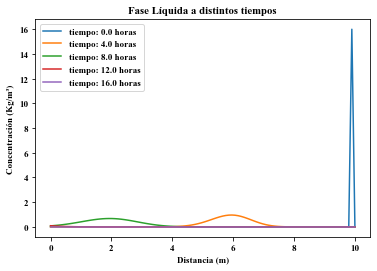

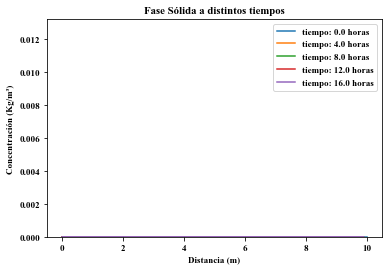

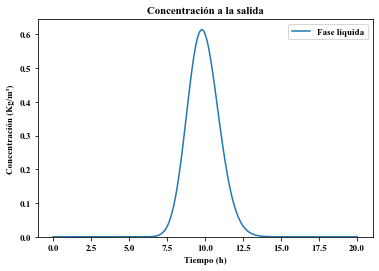


Concentración final: -0.0
rendimiento_solido: 1.007883482757326
rendimiento_liquido: -6.18913845236199e-11



In [20]:
'__Obtención de gráficos__'


# Definición de un tiempo inicial para analizar y el máximo índice de z
zEnd = int(nz)

# Concentración a la salida del extractor
Yin  = Y[:, -1]
Yout = Y[:,  1]
Xin  = X[:,  1]
Xout = X[:, -1]

resTimePos = find_nearest_pos(t, resTimeL)

# Obtengo tiempos a los cuales deseo extraerles información
tiempos = []
for i in range(0, int(nt), int((nt)/5)):
    tiempos.append(i)

# Grafico concentraciones de fase líquida
for i in tiempos:
    plt.plot(Z[:zEnd], Y[i, :zEnd], label=f'tiempo: {round(t[i]/3600, 1)} horas')


plt.title('Fase Líquida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()


# Grafico concentraciones de fase sólida
for i in tiempos:
    plt.plot(Z[:zEnd], X[i, :zEnd], label=f'tiempo: {round(t[i]/3600, 1)} horas')

plt.title('Fase Sólida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.ylim(ymin=0)
plt.legend()
plt.show()


# Grafico concentración a la salida del extractor
plt.plot(t[:]/3600, Yout[:], label='Fase líquida')
plt.title('Concentración a la salida')
plt.xlabel('Tiempo (h)')
plt.ylabel('Concentración (Kg/m³)')
plt.ylim(ymin=0)
plt.legend()
plt.show()


rendimiento_liquido = (Yout[-1]*L)/(porcentajeAC*W)
rendimiento_solido = 1 - Xout[-1]/(porcentajeAC*dens)

print(f'''
Concentración final: {round(Yout[-1],2)}
rendimiento_solido: {rendimiento_solido}
rendimiento_liquido: {rendimiento_liquido}
''')


In [21]:
rendimiento_liquido/rendimiento_solido

-6.140728128047104e-11